In [1]:
import re

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer
import warnings

warnings.filterwarnings("error")

In [2]:
seed = 48

In [4]:
tar_features = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
tar_sd_features = ['X4_sd', 'X11_sd', 'X18_sd', 'X50_sd', 'X26_sd', 'X3112_sd']
log_features = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [4]:
train = pd.read_csv('./data/train.csv', index_col='id').fillna(0)
# train = train + 1e-5

In [6]:
train_xs, valid_xs = train_test_split(train, test_size=0.2, random_state=seed)
train_xs.shape, valid_xs.shape

((44391, 175), (11098, 175))

In [6]:
# for mean, sd in zip(tar_features, tar_sd_features):
#     print(mean, sd)
#     train[mean] = train[mean] + train[sd] * np.random.normal(0, 0.1, len(train))

In [7]:
train_xs[tar_features].describe().T

,count,mean,std,min,25%,50%,75%,max
X4_mean,44391.0,0.522885,1.758845e-01,-2.431157e+00,0.411067,0.508919,0.622760,4.475172e+00
X11_mean,44391.0,159.569755,1.428773e+04,6.780000e-05,10.626319,15.116270,19.680132,1.504254e+06
X18_mean,44391.0,24578.633284,2.582359e+06,2.330000e-08,0.313851,0.720825,3.635854,2.720494e+08
X50_mean,44391.0,12.802032,1.313423e+03,9.680000e-05,1.172768,1.478612,1.926010,1.597599e+05
X26_mean,44391.0,3597.055443,2.623069e+05,5.500000e-07,0.572460,2.539143,15.073373,3.106555e+07
X3112_mean,44391.0,493868.681020,1.023270e+08,7.690000e-08,257.437398,726.808928,2146.463677,2.155911e+10


In [7]:
train_xs[tar_features].quantile([0, 0.01, 0.025, 0.1, 0.5, 0.9, 0.975, 0.99, 1]).T

,0.000,0.010,0.025,0.100,0.500,0.900,0.975,0.990,1.000
X4_mean,-2.431157e+00,0.227783,0.273426,0.338843,0.508919,0.724688,0.841314,0.920310,4.475172e+00
X11_mean,6.780000e-05,3.057649,3.967288,6.421923,15.116270,25.246879,38.378333,50.777775,1.504254e+06
X18_mean,2.330000e-08,0.042790,0.064821,0.163245,0.720825,11.397470,21.751872,28.564947,2.720494e+08
X50_mean,9.680000e-05,0.492535,0.642466,0.925622,1.478612,2.491684,3.515410,4.444901,1.597599e+05
X26_mean,5.500000e-07,0.010774,0.021041,0.120801,2.539143,80.104639,537.145107,1454.708615,3.106555e+07
X3112_mean,7.690000e-08,11.708036,21.933505,91.904776,726.808928,4844.990136,13641.992446,24493.446280,2.155911e+10


In [6]:
trimmer = OutlierTrimmer(capping_method='quantiles', tail='both', fold=0.025)
trimmer.fit(train_xs[tar_features])

OutlierTrimmer(capping_method='quantiles', fold=0.025, tail='both')

In [8]:
targets = trimmer.transform(train_xs[tar_features])
targets

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
id,,,,,,
196351112,0.345967,18.729455,6.097319,0.983611,0.110296,8217.136933
194199029,0.788713,22.499436,0.079323,2.344849,22.024522,675.009501
130253467,0.662078,12.631095,0.753300,2.763913,15.101902,265.980344
188664637,0.458969,10.782423,0.100319,2.669681,2.557434,94.730622
193127917,0.418326,20.423378,0.214306,0.931081,0.295317,256.789938
...,...,...,...,...,...,...
175046078,0.339802,24.384134,0.764263,1.547853,2.013367,3965.267810
191833808,0.656199,12.897281,1.526435,2.695139,18.236375,320.115284
195878907,0.556858,14.144586,0.722631,3.464295,3.489664,837.110254


In [9]:
val_targets = trimmer.transform(valid_xs[tar_features])
val_targets

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
id,,,,,,
194891447,0.680353,8.897225,21.364594,3.129161,50.941272,1080.646170
191770603,0.476163,16.691173,0.473854,0.958628,0.078599,798.094415
196541825,0.613250,12.979986,4.563588,1.313577,3.191662,3213.977560
194014257,0.546773,19.176414,0.121865,1.329584,0.332680,209.330816
18647018,0.484643,8.985343,7.918931,2.050727,100.963345,2930.197690
...,...,...,...,...,...,...
28547380,0.529505,15.555081,0.498518,1.327774,12.110630,1822.060834
149717313,0.436301,12.386403,12.460742,1.689838,45.965060,5263.455160
196471504,0.441506,21.160422,4.785422,1.398361,4.658262,3875.831403


In [10]:
scaler = MinMaxScaler()
y_train = np.zeros_like(targets[tar_features], dtype=np.float32)

for idx, (target, tar_sd) in enumerate(zip(tar_features, tar_sd_features)):
    v = targets[target].values

    if target in log_features:
        v = np.log10(v)

    y_train[:, idx] = v

y_train = scaler.fit_transform(y_train)

In [11]:
y_val = np.zeros_like(val_targets[tar_features], dtype=np.float32)

for idx, (target, tar_sd) in enumerate(zip(tar_features, tar_sd_features)):
    v = val_targets[target].values

    if target in log_features:
        v = np.log10(v)

    y_val[:, idx] = v

y_val = scaler.transform(y_val)

In [12]:
y_train = pd.DataFrame(y_train, columns=tar_features).set_index(targets.index)
y_val = pd.DataFrame(y_val, columns=tar_features).set_index(val_targets.index)

In [13]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
X4_mean,34568.0,0.427232,0.232860,0.0,0.242273,0.395716,0.602365,1.0
X11_mean,34568.0,0.565828,0.196484,0.0,0.462638,0.595680,0.698325,1.0
X18_mean,34568.0,0.466775,0.244369,0.0,0.280215,0.410720,0.662474,1.0
X50_mean,34568.0,0.500785,0.195448,0.0,0.370297,0.489849,0.631514,1.0
X26_mean,34568.0,0.483593,0.209438,0.0,0.337393,0.472687,0.630464,1.0
X3112_mean,34568.0,0.544380,0.207406,0.0,0.400041,0.542709,0.703003,1.0


In [14]:
y_val.describe().T

,count,mean,std,min,25%,50%,75%,max
X4_mean,8541.0,0.428179,0.233592,0.000039,0.242148,0.398560,0.602690,0.998844
X11_mean,8541.0,0.567688,0.192729,0.000690,0.466755,0.594752,0.696066,0.999724
X18_mean,8541.0,0.462358,0.243832,0.000000,0.275063,0.406181,0.655000,0.999874
X50_mean,8541.0,0.504041,0.195852,0.000000,0.375308,0.494284,0.632554,1.000000
X26_mean,8541.0,0.480511,0.209046,0.000424,0.333056,0.470840,0.630269,0.999513
X3112_mean,8541.0,0.543430,0.209021,0.000052,0.396907,0.542718,0.703248,0.999986


In [15]:
train_boxes = pd.read_csv('./data/boxes.csv', index_col='id')

In [16]:
train_boxes['box'] = train_boxes['box'].apply(lambda x:
                                              np.fromstring(
                                                  x.replace('\n', '')
                                                  .replace('[', '')
                                                  .replace(']', '')
                                                  .replace('  ', ' '), sep=' '))

In [17]:
full_train = y_train.join(train_boxes, how='inner')
full_valid = y_val.join(train_boxes, how='inner')

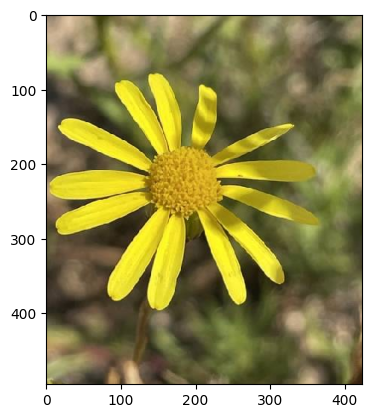

In [19]:
idx = 110629751
img = cv2.imread(f'./data/train_images/{idx}.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

box = full_train.loc[idx, 'box']
patch = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
plt.imshow(patch)

In [18]:
full_train.to_csv('./data/processed/train.csv')
full_valid.to_csv('./data/processed/valid.csv')
dump(scaler, './data/processed/scaler.joblib')

['./data/processed/scaler.joblib']

In [19]:
test = pd.read_csv('./data/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'./data/test_images/{s}.jpeg')
test['jpeg_bytes'] = test['file_path'].apply(lambda fp: open(fp, 'rb').read())
test.to_pickle('./data/test.pkl')

Exception ignored in: <_io.FileIO name='./data/test_images/195066138.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_25176\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/195524180.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_25176\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/172220512.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_25176\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/195824490.jpeg' mode='rb' closefd=True>
Traceback (most recent call last):
  File "C:\Users\ashen\AppData\Local\Temp\ipykernel_25176\1100144305.py", line 3, in <lambda>
Exception ignored in: <_io.FileIO name='./data/test_images/191793047.jpeg' mode='rb' clo

In [20]:
test

In [7]:
train_scaler = MinMaxScaler()
x_train = np.zeros_like(train[x_feature], dtype=np.float32)

for idx, target in enumerate(x_feature):
    v = train[target].values

    # if target in log_x_features:
    #     v = np.log10(v)

    x_train[:, idx] = v

x_train = train_scaler.fit_transform(x_train)

In [10]:
x_train = pd.DataFrame(x_train, columns=x_feature).set_index(train.index)

In [11]:
x_train

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
id,,,,,,,,,,,,,,,,,,,,,
192027691,-0.308725,-0.889802,-0.554512,0.490021,0.805016,0.879735,0.460272,0.579818,0.487341,0.633997,...,0.638743,0.927605,1.040217,0.817117,0.347126,0.213268,0.384477,0.644727,0.544614,0.236286
195542235,0.355134,-1.259414,-0.936992,-0.583946,1.075379,1.615380,0.403478,0.248144,0.612104,0.505870,...,-0.768723,-0.881663,-0.942067,-1.069347,-1.022200,-1.020704,-0.940234,-0.787698,-0.648572,-0.492379
196639184,-0.042541,-0.203696,-0.648946,-1.225982,-0.412910,-0.264452,-0.562008,-0.481537,-0.573140,-0.583211,...,0.488973,0.413616,0.405373,0.406568,0.344944,0.294744,0.386658,0.516051,0.623689,0.651859
195728812,0.541083,0.539962,0.182802,-0.369732,-0.434778,-0.523488,0.176305,-0.614206,-0.198853,-0.262893,...,-0.321266,-0.438934,-0.559986,-0.635205,-0.534976,-0.460638,-0.527141,-0.260902,-0.219068,-0.193552
195251545,-1.833272,-0.687428,-0.640040,-0.583637,2.541932,2.258165,-1.470702,0.380814,-0.510759,0.185552,...,-0.128926,0.260018,0.553307,1.199778,1.516921,1.560907,1.258588,0.767458,0.616531,0.594171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190558785,0.645423,-1.058427,-0.726033,0.326497,-0.145290,0.276630,0.062718,-0.017194,0.175435,0.057425,...,-0.721367,-0.690451,-0.596856,-0.525751,-0.424501,-0.321623,-0.282681,-0.401587,-0.571184,-0.637861
194523231,-0.112469,0.508838,0.176645,-0.428751,0.423243,0.160330,0.460272,0.248144,0.424960,0.377743,...,-0.646642,-0.603014,-0.496135,-0.497384,-0.377590,-0.402016,-0.473746,-0.457392,-0.553931,-0.624018
195888987,0.021632,-0.620095,-0.212108,1.026921,-0.036127,0.180030,0.062718,0.977825,0.487341,0.698061,...,-1.581710,-1.633348,-1.668236,-1.719123,-1.754660,-1.738011,-1.750808,-1.761985,-1.816742,-1.792120


In [12]:
x_train.to_csv('./data/processed/train_x.csv')
dump(train_scaler, './data/processed/scaler_x.joblib')

['./data/processed/scaler_x.joblib']